### Evaluating Model Performance: Boston Home Prices
Given a data set where each row is a neighborhood, each column is a feature of that neighborhood (like crime rate), and one column is the median house price in that area, how well do various regression models predict the median home price for a given neighborhood? In this analysis I'll use a well known dataset--often used to benchmark algorithms--which contains information collected by the U.S Census Service concerning housing in the area of Boston Massachusetts. 

The data are available to load from Scikit-Learn, and you can read more about it [here](https://scikit-learn.org/stable/datasets/index.html#boston-dataset).

---
##### Columns in the data set:
- `CRIM`: per capita crime rate by town
- `ZN`: proportion of residential land zoned for lots over 25,000 sq.ft.
- `INDUS`: proportion of non-retail business acres per town
- `CHAS`: Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- `NX`: nitric oxides concentration (parts per 10 million)
- `RM`: average number of rooms per dwelling
- `AGE`: proportion of owner-occupied units built prior to 1940
- `DIS`: weighted distances to five Boston employment centres
- `RAD`: index of accessibility to radial highways
- `TAX`: full-value property-tax rate per $10,000
- `PTRATIO`: pupil-teacher ratio by town
- `B`: 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town

- `LSTAT`: percent lower status of the population
- `MEDV`: Median value of owner-occupied homes in $1000’s

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
%matplotlib inline 


In [87]:
# Read the CSV file into a DataFrame
df = pd.read_csv('datasets/boston.csv')

# Explore the dataframe
df.head()

,CRIM,ZN,INDUS,CHAS,NX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


#### Exploratory Data Analysis
MEDV is the median value of owner-occupied homes in $1000’s (this is back in the 1970s, mind you). Given that I'll explore how well the features we have are correlated with median home prices.

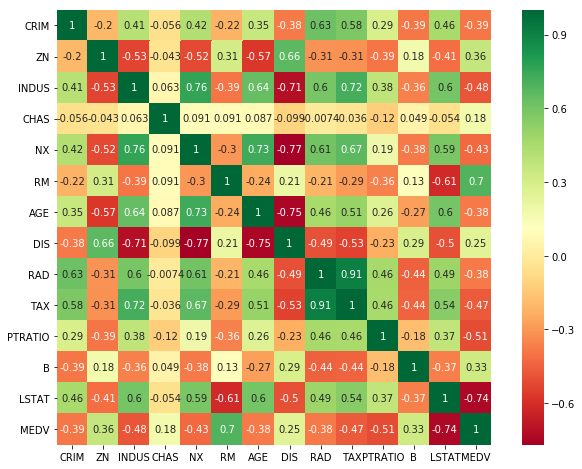

In [88]:
# Plot the correlation between MEDV (dependant or target variable) and the rest of features (independant variables).
plt.figure(figsize=(11, 8))
sns.heatmap(
    df.corr(),
    annot=True,
    square=True, 
    cmap='RdYlGn')

#### Plotting Individual Features Verus MEDV
You can see from the heat map above that `MEDV` is more positively correlated with `RM` (average number of rooms) than any other of the features available. Similarly there appears to be several features, like `CRIM` (per capita crime rate), which are negatively correlated with `MEDV`. Let's take a closer look at `MEDV` versus `RM` and `CRIM` respectively.

In [89]:
# Create arrays for the feature and target variables
y = df['MEDV'].values
X = df.drop('MEDV', axis=1).values

# Slice an array which contains only the RM column
X_rooms = X[:,5]

# Reshape both y and X_rooms--keep the first dimension and adding an additional dimension of size 1 to X_rooms
y = y.reshape(-1,1)
X_rooms = X_rooms.reshape(-1,1)

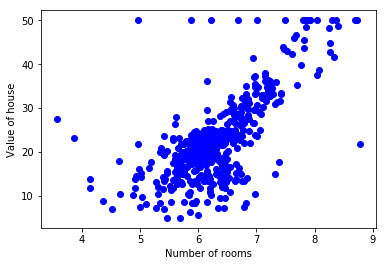

In [90]:
# Plot home price vs number of rooms
plt.scatter(X_rooms, y, color='blue')
plt.ylabel('Value of house')
plt.xlabel('Number of rooms')
plt.show()

#### More Rooms Means Higher Prices
Generally speaking we can see that home prices increase as the number of rooms in a house increases. Just eyeballing the scatter plot one could imagine a line with a positive slope and a certain y-intercept which would probably estimate the correlation between home prices and the number of rooms.

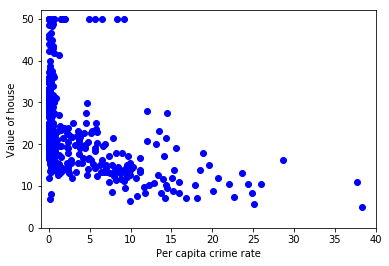

In [91]:
# Slice an array which contains only the CRIM column
X_crim = X[:,0]

# Reshape both X_crim (y was reshaped previously)
X_rooms = X_rooms.reshape(-1,1)

# Plot home price vs number of rooms
plt.scatter(X_crim, y, color='blue')
plt.axis([-1, 40, 0, 52])
plt.ylabel('Value of house')
plt.xlabel('Per capita crime rate')
plt.show()

#### More Crime Means Lower Home Prices
And now we can clearly see the negative correlation which exists between crime rates and median home prices. Similar to the last plot, one could imagine a line with a negative slope and a certain y-intercept which could estimate the correlation between the median home prices in a neighborhood and the per capita crime rate. However, in both cases a degree of error (or loss) will be observed given the range of values that deviate from that line.

To get a better sense for what I'm getting at I'll build a model based a single feature, `RM`, fit it to the data, and then plot the resulting line on top of the scatter plot. 

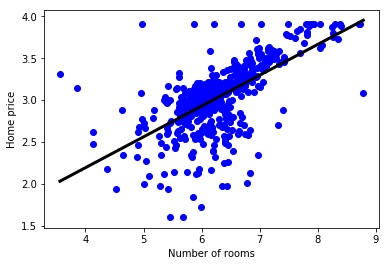

In [120]:
# Instantiate a linear regressor
reg = LinearRegression()

# Fit the model to the data
reg.fit(X_rooms, y)

# Create the prediction space
prediction_space = np.linspace(min(X_rooms), 
                               max(X_rooms)).reshape(-1,1)

# Plot price vs number of rooms
plt.scatter(X_rooms, y, color='blue') 
plt.ylabel('Home price')
plt.xlabel('Number of rooms')

# Plot a regression line against home price vs. number of rooms
plt.plot(prediction_space, 
         reg.predict(prediction_space),
         color='black', 
         linewidth=3)

# Display the new plot
plt.show()

#### Regression Line
Great! We can clearly see how the line estimates the numbers of rooms in a house with the price of a home. But we can also see a number of points with some vertical distance away from the fitted line. As I continue on, we'll want the line to be as close to the actual data points as possible–-that would indicate that the model performs well. For this reason, we should aim to minimize the vertical distance between the fit and the data--this distance is called a residual. 

Next, I'll incorporate all the features and aim to minimize the sum of the squares of the residuals--a common loss function--with Ordinarly Least Squares (OLS for short). Sklearn's `LinearRegression` function performs OLS under the hood, and we'll see that in action shortly. 

For now, we need a statistic to measure our model's performance.

In [93]:
# Print R-squared score
print(reg.score(X_rooms, y))

0.4835254559913343


#### R-squared
One way of measuring a linear model's performance is with R-squared, which is the proportion of the variance in the dependent variable that is predictable from the independent variable, between 0 and 1, where values closer to 1 indicates that the model explains all the variability of the response data around its mean, and thus a better fit. However, ... SOMETHING ABOUT OVERFITTING DATA.

Wow, okay, `0.483` may not seem like a great R-squared score, however, we're only using one feature. Will adding more features improve our model?

#### Training data and testing data
An effective model is one which performs well on unseen data. That is to say, we want to train our data to perform well, and then test how well it performs on data it hasn't seen yet. Model's that perform as well or near as well on unseen data as they do training data can be said to have avoided the overfitting problem. As such I'll need to split the data up into a training set and a testing set. 

In [94]:
y = np.log(df['MEDV'].values)
X = df.drop('MEDV', axis=1).values

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instanstiate a linear regressor
reg = LinearRegression()

# Fit the model to the training data
reg.fit(X_train, y_train)

# Predict on the test set
y_pred_1 = reg.predict(X_test)

# Compute and print the metrics
r2 = reg.score(X_test, y_test)
OLS_rmse = np.sqrt(mean_squared_error(y_test, y_pred_1))
train_r2 = reg.score(X_train, y_train)

print("Baseline R-squared: {}".format(r2))
print("Baseline RMSE: {}".format(OLS_rmse))
print("R squared of the training data: {}".format(train_r2))

Baseline R squared: 0.760469488061
Baseline MSE: 0.191998103231
R squared of the training data: 0.793551534664


#### Establishing Baseline Statistics
Using Sklearn's `LinearRegression` function which uses OLS as a loss function, I've establish baseline statistics for which we can evaluate how well other models perform by comparison. 

BASELINE R2 VS TRAINING:
```
Baseline R squared: 0.760469488061
R squared of the training data: 0.793551534664```

#### Mean Squared Error
In addition to R-squared, `MSE` should be used to evaluate the efficacy of a linear regression. To check the level of error of a model, we call Mean Squared Error on `y_test` and `y_pred`. It is a measure of the average of the squares of error. More simply, it checks the difference between actual values and the predicted values. 

By measuring the average of the squares of error, the `MSE` represents how close a fitted line is to the data points. Another metric that we often calculate is the Root Mean Squared Error (`RMSE`), which rather conviently has the same units as the quantity plotted on the vertical axis (in our case dollars). The `RMSE` is thus the distance, on average, of a data point from the fitted line, measured along a vertical line.


`Baseline MSE: 0.191998103231`


#### Plotting the Model
What we're left with are only the most predictive feature for which we can build a more robust tuned model. A plot of a linear regressor with only these features follows.

Text(0.5,1,'Prices vs Predicted prices')

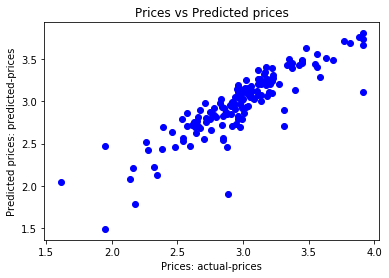

In [95]:
# Plot the values of the regression model
plt.scatter(y_test, y_pred_1, color='blue')
plt.xlabel("Prices: actual-prices")
plt.ylabel("Predicted prices: predicted-prices")
plt.title("Prices vs Predicted prices")

##### Cross Validation
Ridge

In [96]:
# Instantiate a ridge rgressor
ridge = Ridge(alpha=.1, normalize=True)

# Perform 5-fold cross-validation
ridge_cv = cross_val_score(ridge, X, y, cv=5)

# Print the cross-validated scores
print(ridge_cv)
print("Average five-fold CV: {}".format(np.mean(ridge_cv)))

[0.75436849 0.77299911 0.64353916 0.48164707 0.52672811]
Average five-fold CV: 0.635856389378


##### Decision Tree Regression

In [113]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

# Setup the parameters and distributions to sample from
param_dist = {"max_depth": [8, None],
              "max_features": [13, None],
              "min_samples_leaf": range(1, 11),
              "criterion": ['mse', 'friedman_mse']}

# Instantiate a Decision Tree classifier
tree = DecisionTreeRegressor()

# Instantiate the RandomizedSearchCV object
tree_cv = GridSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X_train, y_train)

y_pred_2 = tree_cv.predict(X_test)

# Compute and print the metrics
tree_r2 = tree_cv.score(X_test, y_test)
Tree_rmse = np.sqrt(mean_squared_error(y_test, y_pred_2))

print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
#print("Best score is {}".format(tree_cv.best_score_))
print("Tuned Decision Tree R-squared: {}".format(tree_r2))
print("Tuned Decision Tree RMSE: {}".format(Tree_rmse))

Tuned Decision Tree Parameters: {'max_features': 13, 'criterion': 'mse', 'max_depth': 8, 'min_samples_leaf': 8}
Best score is 0.762175249311
0.770293035060354
0.18801980535707802


#### Random Forest Regression

In [109]:
from sklearn.ensemble import RandomForestRegressor

# Setup the parameters and distributions to sample from
param_dist = {"max_depth": range(1, 11),
              "max_features": [13, None],
              "min_samples_leaf": range(1, 11),
              "criterion": ['mse', 'mae']}

# Instantiate a Decision Tree classifier
forest = RandomForestRegressor()

# Instantiate the RandomizedSearchCV object
forest_cv = GridSearchCV(forest, param_dist, cv=5)

# Fit it to the data
forest_cv.fit(X_train, y_train)

y_pred_3 = forest_cv.predict(X_test)

# Compute and print the metrics
forest_r2 = forest_cv.score(X_test, y_test)
forest_rmse = np.sqrt(mean_squared_error(y_test, y_pred_3))


print("Tuned Random Forest Parameters: {}".format(forest_cv.best_params_))
#print("Best score is {}".format(forest_cv.best_score_))
print("Tuned Random Forest R-Squared: {}".format(forest_r2))
print("Tuned Random Forest RMSE: {}".format(forest_rmse))

Tuned Random Forest Parameters: {'max_features': 13, 'criterion': 'mse', 'max_depth': 9, 'min_samples_leaf': 1}
Best score is 0.821842106777
0.8073934936130555
0.1721678253171633


#### Conclusion

I'd hesitate to use this in the real world, seeing as the range of predictions for a single data point covers nearly a standard deviation of the data set it was trained on. Though 'MDEV' was scaled for inflation, that does not account for changes in housing demand within the city since the 1970s, and outside urban areas, features like teacher/student ratio may not correlate with selling price in the same way. We might also be concerned that this model is too simple to capture other indicators of selling price, like school proximity, condition of the house, or crime rate. In summary, with a few tweaks, the model could be adapted to modern Boston, but would be near useless anywhere else.

In [114]:
print("RMSE OLS: ${}".format(np.exp(OLS_rmse) * 1000.0))
print("RMSE Decision Tree: ${}".format(np.exp(Tree_rmse) * 1000.0))
print("RMSE Random Forest: ${}".format(np.exp(forest_rmse) * 1000.0))

RMSE OLS: $1211.66821871
RMSE Decision Tree: $1206.85741736
RMSE Random Forest: $1187.87717235


In [118]:
# log values?
result = pd.DataFrame({'actual':np.exp(y_test), 
#                       'OLS_predicted':np.exp(y_pred_1), 
#                       'Tree_predicted':np.exp(y_pred_2),
                       'Forest_predicted':np.exp(y_pred_3)})
print(result.head(10))

   Forest_predicted  actual
0         22.663483    23.6
1         29.934247    32.4
2         16.600001    13.6
3         22.881190    22.8
4         17.184011    16.1
5         21.071659    20.0
6         19.173969    17.8
7         14.173932    14.0
8         21.330414    19.6
9         19.943700    16.8


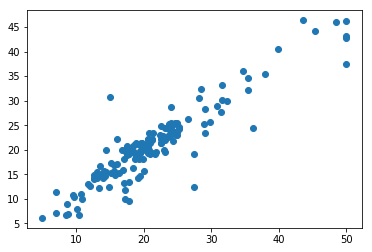

In [119]:
plt.scatter(result.actual, result.Forest_predicted)
plt.xlabel("Prices: actual-prices")
plt.ylabel("Predicted prices: predicted-prices")
plt.title("Prices vs Predicted prices")
plt.show()